In [6]:
import importlib
import ubx_parser
from matplotlib import pyplot as plt
import importer
import math
from pyproj import Proj
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from geopy.distance import great_circle
import utils
from scipy.signal import butter,filtfilt



In [9]:
import importer
import importlib
importlib.reload(importer)


path = './simra_records/'

dfs = importer.import_files(path)

 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

./simra_records/A2_1_jacket 0
./simra_records/Mi9_2_jacket 1


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

./simra_records/Mi9_1_jacket 2
./simra_records/A2_2_jacket 3


In [10]:
def find_velocity_spikes(df):
    threshold = df['a'].std() * 0.8
    print(df['a'].std(), threshold)

    return ((df[~df.velo.isnull()]['a'] > threshold) & (df[~df.velo.isnull()].shift(-1)['a'] < -threshold))



In [11]:
df = dfs[2]  # exemplary ride used. Can be any.

# preprocess code adapted from importer.py

simplify = True
g = 9.81

df['G_raw'] = df.apply(lambda x: np.array([x['X'], x['Y'], x['Z']]), axis=1)

df['date'] = utils.interpolate_dates(df, 'date')

# cf = DataFrame with only Coord Entries
cf = df[~df['date_raw'].isnull()]
cf_shift = cf.shift(1)

cf['l_lon'] = cf_shift['lon']
cf['l_lat'] = cf_shift['lat']
cf = cf[~cf['l_lon'].isnull()]
cf['duration'] = (cf['date_raw'] - cf_shift['date_raw']).dt.total_seconds()
cf['dist'] = cf.apply(lambda x: great_circle([x['l_lat'], x['l_lon']], [x['lat'], x['lon']]).meters, axis=1)
cf['velo'] = cf['dist'] / cf['duration']

cf_shift = cf.shift(1)

cf['a'] = (cf['velo'] - cf_shift['velo']) / cf['duration']

# cf = eliminate_velo_spikes(cf)

# cf['a_abs'] = (cf['velo'] - cf.shift(1)['velo']) / cf['duration']

proj = Proj('epsg:5243')

proj_coords = cf.apply(lambda x: proj(x['lon'], x['lat']), axis=1)
cf.loc[:, ['x', 'y']] = list(map(list, proj_coords))

cf['dir_x'] = cf['x'] - cf.shift(1)['x']
cf['dir_y'] = cf['y'] - cf.shift(1)['y']
cf['velo_vec'] = cf.apply(lambda x: utils.resize_vector_to_one(np.array([x['dir_x'], x['dir_y']])) * x['velo'], axis=1)
cf['a_wrld'] = cf.apply(
    lambda x: np.nan_to_num(np.hstack([utils.resize_vector_to_one(np.array([x['dir_x'], x['dir_y']])) * x['a'], g])),
    axis=1)

cf['a_bike'] = cf.apply(lambda x: np.nan_to_num(np.array([x['a'], 0, g])), axis=1)

df['duration'] = cf['duration']
df['velo'] = cf['velo']
df['velo_vec'] = cf['velo_vec']
df['velo_vec'] = df['velo_vec'].fillna(method='bfill')
df['a_bike'] = cf['a_bike']
df['a'] = cf['a']
df['a_wrld'] = cf['a_wrld']
df['x'] = cf['x']
df['y'] = cf['y']
df['x'] = df['x'].interpolate()
df['y'] = df['y'].interpolate()
df['dist'] = cf['dist']

df['G_size'] = df.apply(lambda x: np.linalg.norm(x['G_raw']), axis=1)

first_velo_entry = df[~df['velo'].isnull()].iloc[0].id
last_velo_entry = df[~df['velo'].isnull()].iloc[-1].id
df_cut = df[first_velo_entry:last_velo_entry + 1]

df_cut['a_bike'] = df_cut['a_bike'].fillna(method='backfill')
df_cut['a_wrld'] = df_cut['a_wrld'].fillna(method='backfill')

df_cut['a_size'] = df_cut.apply(lambda x: np.linalg.norm(x['a_bike']), axis=1)

df_cut['spike'] = find_velocity_spikes(df_cut)

df_cut['section'] = df_cut['spike'].cumsum()
df_cut['section'] = df_cut.apply(lambda x: int(x['section']) if x['spike'] is False else -1, axis=1)

if simplify:
    df = df[~df['date_raw'].isnull()]
    df = df.drop(['X', 'Y', 'Z', 'XL', 'YL', 'ZL', 'RX', 'RY', 'RZ', 'RC', 't_int', 'date_raw'], axis=1)    

f = 250
t = 300

raw = df_cut.velo.dropna()[f:t].values
indices = df_cut.id.dropna()[f:t].values
#df_cut.a.dropna()[f:t].plot()
k=9
new = df_cut[df_cut.spike == False].velo.dropna()[f-k:t-k].values

#df_cut[df_cut.spike == True]

1.0414853908992663 0.8331883127194131


In [12]:
raw = df_cut[['coord_index', 'velo']].dropna()[f:t].to_numpy()


In [13]:
new = df_cut[df_cut.spike == False][['coord_index', 'velo']].dropna()[f-k:t-k-2].to_numpy()


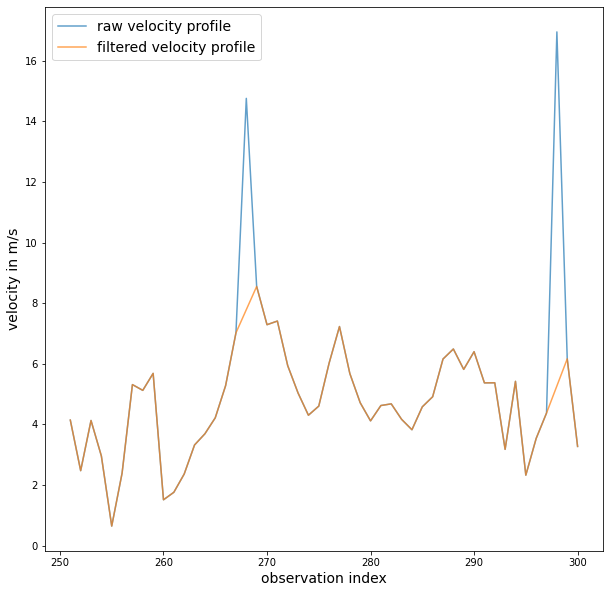

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(raw[:,0], raw[:,1], alpha=0.7, label='raw velocity profile')
plt.plot(new[:,0], new[:,1], alpha=0.7, label='filtered velocity profile')
plt.ylabel('velocity in m/s', fontsize=14)
plt.xlabel('observation index', fontsize=14)
plt.legend(fontsize=14)

plt.savefig("images/velo_spike_finder.png", bbox_inches='tight')

